In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from capsnet import CapsNet

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/')
batch_size = 100

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
tf.reset_default_graph()

In [3]:
tf.random.set_random_seed(0)
np.random.seed(0)

In [4]:
checkpoint_file = './tmp/model.ckpt'

In [5]:
def train(model, restore = False, n_epochs = 50):
    init = tf.global_variables_initializer()	

    n_iter_train_per_epoch = mnist.train.num_examples // batch_size
    n_iter_valid_per_epoch = mnist.validation.num_examples // batch_size

    best_loss_val = np.infty
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter("output", sess.graph)

        if restore and tf.train.checkpoint_exists('checkpoint_file'):
            saver.restore(sess, checkpoint_file)
        else:
            init.run()

        print('\n\nRunning CapsNet ...\n')
        for epoch in range(n_epochs):
            loss_train_ep = []
            acc_train_ep  = []
            for it in range(1, n_iter_train_per_epoch + 1):
                X_batch, y_batch = mnist.train.next_batch(batch_size)

                _, loss_batch_train, acc_batch_train = sess.run(
                                [model.train_op, model.batch_loss, model.accuracy],
                                feed_dict = {model.X: X_batch.reshape([-1, 28, 28, 1]),
                                                model.y: y_batch,
                                                model.reconstruction: True})

                print("\rIter: {}/{} [{:.1f}%] loss : {:.5f}".format(
                    it, n_iter_train_per_epoch, 100.0 * it / n_iter_train_per_epoch, loss_batch_train), end="")

                loss_train_ep.append(loss_batch_train)
                acc_train_ep.append(acc_batch_train)
            loss_train = np.mean(loss_train_ep)
            acc_train = np.mean(acc_train_ep)
            
            loss_val_ep = []
            acc_val_ep  = []

            for it in range(1, n_iter_valid_per_epoch + 1):
                X_batch, y_batch = mnist.validation.next_batch(batch_size)
                loss_batch_val, acc_batch_val = sess.run(
                                [model.batch_loss, model.accuracy],
                                feed_dict = {model.X_cropped: X_batch.reshape([-1, 28, 28, 1]),
                                                model.y: y_batch})

                loss_val_ep.append(loss_batch_val)
                acc_val_ep.append(acc_batch_val)

                print("\rValidation {}/{} {:.1f}%".format(it, n_iter_valid_per_epoch, 100.0 * it / n_iter_valid_per_epoch), end=" "*30)

            loss_val = np.mean(loss_val_ep)
            acc_val  = np.mean(acc_val_ep)

            print("\repoch: {} loss_train: {:.5f}, loss_val: {:.5f}, train_acc: {:.4f}%, valid_acc: {:.4f}% {}".format(
                epoch + 1, loss_train, loss_val, acc_train * 100.0, acc_val * 100.0, "(improved)" if loss_val < best_loss_val else ""))

            if loss_val < best_loss_val:
                best_loss_val = loss_val
            saver.save(sess, checkpoint_file)
            

        writer.close()

In [6]:
model = CapsNet(rounds = 3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
==>1
==>2
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [7]:
train(model, False, 50)



Running CapsNet ...

epoch: 1 loss_train: 0.15230, loss_val: 0.04156, train_acc: 86.3273%, valid_acc: 98.6000% (improved)
epoch: 2 loss_train: 0.04498, loss_val: 0.03249, train_acc: 98.2273%, valid_acc: 98.9000% (improved)
epoch: 3 loss_train: 0.03562, loss_val: 0.02795, train_acc: 98.7491%, valid_acc: 99.1600% (improved)
epoch: 4 loss_train: 0.03001, loss_val: 0.02591, train_acc: 99.0255%, valid_acc: 99.1800% (improved)
epoch: 5 loss_train: 0.02700, loss_val: 0.02382, train_acc: 99.2273%, valid_acc: 99.1800% (improved)
epoch: 6 loss_train: 0.02386, loss_val: 0.02030, train_acc: 99.3545%, valid_acc: 99.3200% (improved)
epoch: 7 loss_train: 0.02174, loss_val: 0.01937, train_acc: 99.4182%, valid_acc: 99.4800% (improved)
epoch: 8 loss_train: 0.01982, loss_val: 0.01750, train_acc: 99.4909%, valid_acc: 99.5000% (improved)
epoch: 9 loss_train: 0.01832, loss_val: 0.01749, train_acc: 99.5436%, valid_acc: 99.4200% (improved)
epoch: 10 loss_train: 0.01708, loss_val: 0.01560, train_acc: 99.6018

In [8]:
def test(model):
    batch_size = 100

    n_iter_test_per_epoch = mnist.test.num_examples // batch_size

    loss_test_ep = []
    acc_test_ep  = []
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(checkpoint_file +'.meta')
        saver.restore(sess, tf.train.latest_checkpoint('tmp/'))
        
        print("\n")
        for it in range(1, n_iter_test_per_epoch + 1):
            X_batch, y_batch = mnist.test.next_batch(batch_size)
            loss_batch_test, acc_batch_test = sess.run(
                [model.batch_loss, model.accuracy],
                    feed_dict = {model.X_cropped: X_batch.reshape([-1, 28, 28, 1]),
                                model.y: y_batch,
                                model.reconstruction: False})

            loss_test_ep.append(loss_batch_test)
            acc_test_ep.append(acc_batch_test)
            print("\rTesting {}/{} {:.1f}%".format(it, n_iter_test_per_epoch, 100.0 * it / n_iter_test_per_epoch), end=" "*30)	

        loss_test = np.mean(loss_test_ep)
        acc_test  = np.mean(acc_test_ep)

        print("\r(Testing) accuracy: {:.3f}%, loss: {:.4f}".format(acc_test*100.0, loss_test))

In [9]:
test(model)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tmp/model.ckpt


(Testing) accuracy: 99.610%, loss: 0.0087           


In [ ]:
def reconstruction(model, num_samples):
    samples_imgs = mnist.test.images[:num_samples].reshape([-1, 28, 28, 1])

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(checkpoint_file +'.meta')
        saver.restore(sess, tf.train.latest_checkpoint('tmp/'))

        decoder_output, y_pred_value = sess.run(
            [model.decoder_output, model.y_pred],
            feed_dict = {model.X_cropped: samples_imgs})


    samples_imgs = samples_imgs.reshape([-1, 28, 28])
    reconstructions_imgs = decoder_output.reshape([-1, 28, 28])	

    plt.figure(figsize = (num_samples * 2, 4))

    for img_idx in range(num_samples):
        plt.subplot(2, num_samples, img_idx + 1)
        plt.imshow(samples_imgs[img_idx], cmap='gray')
        plt.title("Input: " + str(mnist.test.labels[img_idx]))
        plt.axis("off")

    for img_idx in range(num_samples):
        plt.subplot(2, num_samples, num_samples + img_idx + 1)
        plt.imshow(reconstructions_imgs[img_idx], cmap='gray')
        plt.title("Output: " + str(y_pred_value[img_idx]))
        plt.axis("off")

plt.show()

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


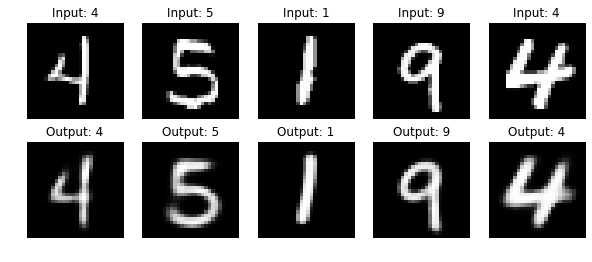

In [11]:
reconstruction(model, 5)